In [1]:
import tensorflow as tf

/usr/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [66]:
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [54]:
def get_weights(n_features, n_labels):
    return tf.Variable(tf.truncated_normal((n_features, n_labels)))

def get_biases(n_labels):
    return tf.Variable(tf.zeros(n_labels))

def linear(X, w, b):
    return tf.add(tf.matmul(X, w), b)

In [4]:
with open('train-labels-idx1-ubyte', 'rb') as f:
    magic, num = struct.unpack(">II", f.read(8))
    lbl = np.fromfile(f, dtype=np.int8)

with open('train-images-idx3-ubyte', 'rb') as f:
    magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
    img = np.fromfile(f, dtype=np.uint8)
    img = img.reshape(len(lbl), rows, cols)

In [5]:
get_img = lambda idx: (lbl[idx], img[idx])

In [6]:
def get():
    for i in range(len(lbl)):
        yield get_img(i)

In [7]:
def show(image):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image.reshape(28, -1), cmap=plt.cm.Greys)
    plt.show()

In [67]:
X = []
y = []

for _ in get():
    if _[0] not in [1, 2, 3]:
        continue
    X.append(_[1].reshape(1, -1))
    y.append(_[0])
X = np.array(X).reshape(-1, 784)
y = np.array(y).reshape(-1, 1)

In [70]:
one_hot = LabelBinarizer()
y = one_hot.fit_transform(y)

In [71]:
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (18831, 784)
y: (18831, 3)


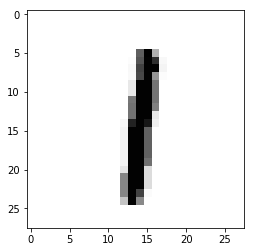

In [72]:
show(X[15])

In [28]:
X = (X - 128) / 128

In [115]:
X_train, X_test,  y_train, y_test = train_test_split(X, y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

print(f'train: {X_train.shape}')
print(f'y train: {y_train.shape}')

train: (10592, 784)
y train: (10592, 3)


In [75]:
with tf.Session() as sess:
    # Initialize session variables
    sess.run(tf.global_variables_initializer())
    
    # Softmax
    prediction = tf.nn.softmax(logits)
    
    # Cross entropy
    cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
    
    # Training loss
    loss = tf.reduce_sum(cross_entropy)
    
    learning_rate = .01
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    _, l = sess.run([optimizer, loss], feed_dict={features: X_train, labels: y_train})

print(f'Loss: {l}')

Loss: nan


In [76]:
eta = .01

n_input = 784
n_class = 3

features = tf.placeholder(tf.float32, [None, n_input], name="features")
labels   = tf.placeholder(tf.float32, [None, n_class], name='labels')

W = get_weights(n_input, n_class)
b = get_biases(n_class)

logits = linear(features, W, b)

In [116]:
def print_epoch_stats(epoch_i, sess, last_features, last_labels):
    """
    Print cost and validation accuracy of an epoch
    """
    current_cost = sess.run(
        cost,
        feed_dict={features: last_features, labels: last_labels})
    valid_accuracy = sess.run(
        accuracy,
        feed_dict={features: X_valid, labels: y_valid})
    print('Epoch: {:<4} - Cost: {:<8.3} Valid Accuracy: {:<5.3}'.format(
        epoch_i,
        current_cost,
        valid_accuracy))

In [141]:
learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Calculate accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epochs = 100
batch_size = 128

with tf.Session() as sess:
    # Initialize session variables
    sess.run(tf.global_variables_initializer())
    
    for _ in range(epochs):
        n_samples = X_train.shape[0]
        n = n_samples // 128
        
        for __ in range(n):
            idx = np.random.choice(range(n_samples), batch_size)
            X_batch = X_train[idx]
            y_batch = y_train[idx]
            
            sess.run(optimizer, feed_dict={features: X_batch, labels: y_batch, learning_rate: .1})

        # Print cost and validation accuracy of an epoch
        print_epoch_stats(_, sess, X_train, y_train)
        
    # Calculate accuracy for test dataset
    test_accuracy = sess.run(
        accuracy,
        feed_dict={features: X_test, labels: y_test})

print('Test Accuracy: {}'.format(test_accuracy))

Epoch: 0    - Cost: 4.44e+02 Valid Accuracy: 0.951
Epoch: 1    - Cost: 9.05e+02 Valid Accuracy: 0.96 
Epoch: 2    - Cost: 3.27e+02 Valid Accuracy: 0.967
Epoch: 3    - Cost: 2.69e+02 Valid Accuracy: 0.962
Epoch: 4    - Cost: 2.23e+02 Valid Accuracy: 0.964
Epoch: 5    - Cost: 2.69e+02 Valid Accuracy: 0.96 
Epoch: 6    - Cost: 2.88e+02 Valid Accuracy: 0.956
Epoch: 7    - Cost: 1.87e+02 Valid Accuracy: 0.962
Epoch: 8    - Cost: 1.99e+02 Valid Accuracy: 0.956
Epoch: 9    - Cost: 3.04e+02 Valid Accuracy: 0.964
Epoch: 10   - Cost: 4.28e+02 Valid Accuracy: 0.94 
Epoch: 11   - Cost: 1.92e+02 Valid Accuracy: 0.963
Epoch: 12   - Cost: 2.09e+02 Valid Accuracy: 0.965
Epoch: 13   - Cost: 1.65e+02 Valid Accuracy: 0.966
Epoch: 14   - Cost: 2.28e+02 Valid Accuracy: 0.965
Epoch: 15   - Cost: 2.04e+02 Valid Accuracy: 0.963
Epoch: 16   - Cost: 2.18e+02 Valid Accuracy: 0.953
Epoch: 17   - Cost: 3.06e+02 Valid Accuracy: 0.965
Epoch: 18   - Cost: 2.32e+02 Valid Accuracy: 0.965
Epoch: 19   - Cost: 1.82e+02 Va

In [135]:
X_train[[0,1]]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [88]:
with tf.Session() as sess:
    output = sess.run(tf.nn.softmax([1.2, .9, .4]))
    
    print(output)

[ 0.45659032  0.3382504   0.20515925]


In [23]:
y_true = tf.placeholder(tf.float32)
y_pred = tf.placeholder(tf.float32)
cross_entropy = -tf.reduce_sum(y_true * tf.log(y_pred))

with tf.Session() as sess:
    output = sess.run(cross_entropy, feed_dict={y_true:[0,0,0,1,0], y_pred:[0.27, 0.11, 0.33, 0.10, 0.19]})
    print(f'Result: {output}')

Result: 2.3025851249694824


In [27]:
(256 - 128) / 128

1.0